In [5]:
!pip install pymatgen -q

In [6]:
from fastai import *
from fastai.vision.all import *

import sys
sys.path.append('..')
from src.band_plotters import *
from src.transforms import Binarize
from src.TensorImageNoised import *

import model

## Load

torch.Size([32, 3, 224, 224])

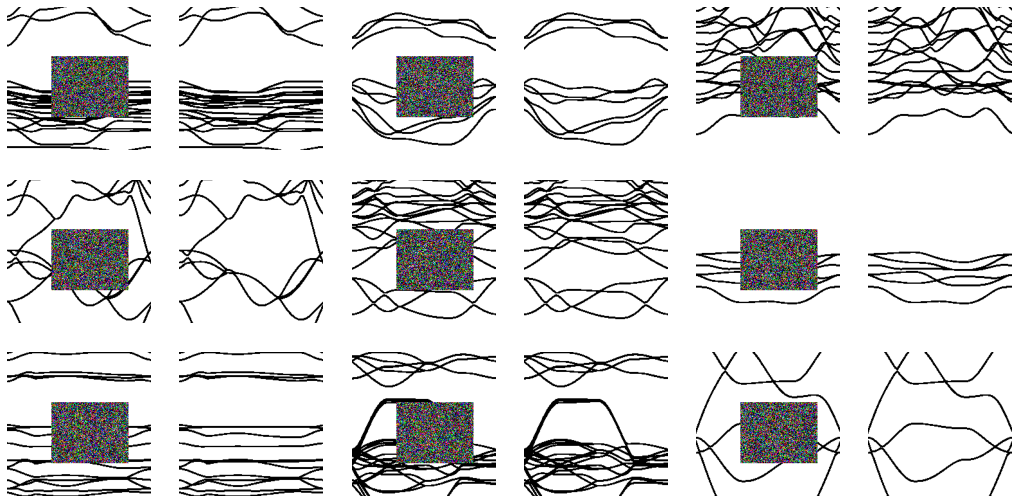

In [7]:
IMAGE_SIZE = 224

dls = DataBlock(
    blocks=(ImageBlock(cls=PILImageNoised), ImageBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    item_tfms=[Resize((IMAGE_SIZE))],
    batch_tfms=[Binarize(), RandomErasingTransform()]
        ).dataloaders(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3", bs=32)

dls.show_batch()

xb, yb = dls.one_batch()
xb.shape

## Train

### Create Learner

In [ ]:
loss = nn.BCEWithLogitsLoss()
sigmoid = True
if isinstance(loss, nn.BCEWithLogitsLoss):
    sigmoid = False

Z_CHANNELS_ARRAY = [2]

for Z_CHANNELS in Z_CHANNELS_ARRAY:
    print("z_channels:", Z_CHANNELS)
    ae = model.BuildAutoEncoder("resnet18", sigmoid=sigmoid, z_channels=Z_CHANNELS)
    learn = Learner(dls, ae, loss, cbs=[ShowGraphCallback()])
    learn.fit_one_cycle(30)

xb, yb = dls.valid.one_batch()
print("latent size:", learn.model.encoder(xb.cuda()).shape)

## Save and Load Learner

In [8]:
# learn.export(f"trained_models/resnet18_size{IMAGE_SIZE}_lossbce_channels{Z_CHANNELS}.pkl")
learn = load_learner("trained_models/resnet18_size224_lossbce_channels2.pkl")

## View Predictions

In [13]:
from ipywidgets import interact

train = False

if train:
    dl = dls.train
else:
    dl = dls.valid
dls.shuffle=False
xb, yb = dls.one_batch()
sigmoid=False

def show(i):
    print(dl.items[i])
    learn.cuda()
    preds = learn.model(xb)
    if not sigmoid:
        preds = torch.sigmoid(preds)
    show_image(xb[i])
    show_image(preds[i])
    
    if not train:
        show_image(yb[i])
    
    image = Image.open(dl.items[i])
    image.show()

    

interact(show, i=(0, len(xb)-1))

interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.show(i)>

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


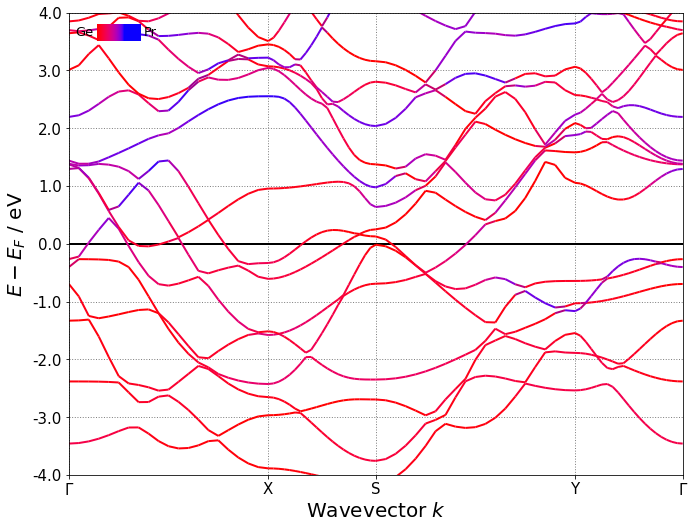

In [49]:
plot("2dm-5299", dos=False)